# Benchmarking and Profiling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/hp/00.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

Recognizing the slow parts of your program is the single most important task when it
comes to speeding up your code. This is because in most cases, the code that causes the application to
slow down is a very small fraction of the program which are called **bottlenecks**. By identifying these critical sections, you can focus on the parts that need the most improvement without wasting time in micro-optimization which lead to marginal speedups relative to parts where the most computation occurs. 

In this notebook, we will write a simulation of a system of particles which move in concentric circles. We will use two techniques **profiling** and **benchmarking** to time our programs. We will also look at memory consumption which can be relevant when our program deals with large data. We also write tests to make sure that any optimization does not break the core logic of our program. Our strategy is to start with a simple conceptual code that works which would allow us to write tests. This would allow us to start optimizing our code. 

**Code:** [[`src`]()] [[`test`]()]

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation

To write simulation code, we divide the code into **objects** and **physics**. The physics of the system determines the update rule for each episode as well as the configuration of the initial episode. Our objects will be particles defined in the `Particle` class. This just contains three variables for position and (signed) angular speed which determine the state of the particle.

In [69]:
from src.particles import Particle, ParticleSimulator

```python
class Particle:
    def __init__(self, x, y, angular_vel):
        self.x = x
        self.y = y
        self.ω = angular_vel
```

The physics of the system is encoded in the `ParticleSimulator` and an initialization function for the particles. This takes in a list of particles as well as a constant `h` which is the increment for the Euler method. This can be interpreted as the quantum of time for the system. 

The simulator defines a method `evolve(t)` which incrementally updates the position of each particle from `t=0` to `t=t`. More precisely to `s = hn` for largest `n` such that `s ≤ t`. Note that same update rule is applied to all particles which makes sense by symmetry. Moreover, the rule is static in that it does not change over time. These two assumptions make up the `evolve` method. The exact update rule is defined in the `update_particle` method. For this simulation, we simply rotate all particles around the origin with a fixed radius based on its initial position and with an angular velocity that is given at initialization.

```python
class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles
        self.data = np.array([[p.x, p.y, p.ω] for p in particles], dtype=np.float32)

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""
        
        n_steps = int(t / self.h)
        for _ in range(n_steps):
            for p in self.particles:
                self.update_particle(p)

    def update_particle(self, p: Particle):
        """Evolve particle with Δt = h."""
        vx = -p.y * p.ω
        vy =  p.x * p.ω
        dx = vx * self.h
        dy = vy * self.h
        p.x += dx
        p.y += dy
```

Visualizing three particles with the same angular velocity. The following shows the time evolution of the system incremented by 1 time units for each frame.

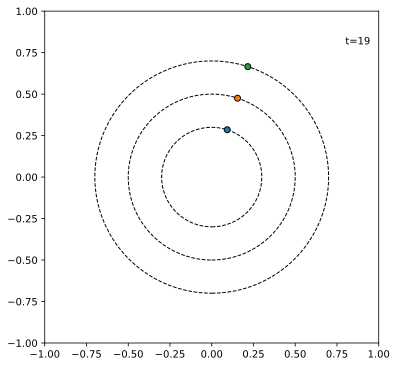

In [70]:
import math
from src.particles import visualize_simulation

particles = [
    Particle(0.0, 0.3, 0.10 * math.pi),
    Particle(0.0, 0.5, 0.10 * math.pi),
    Particle(0.0, 0.7, 0.10 * math.pi)
]

simulator = ParticleSimulator(particles)
visualize_simulation(simulator, timesteps=20, fps=5) # fps = no. time steps per second => 4 second GIF

```{figure} particles.gif
```

For our tests, we consider the following three simple scenarios:

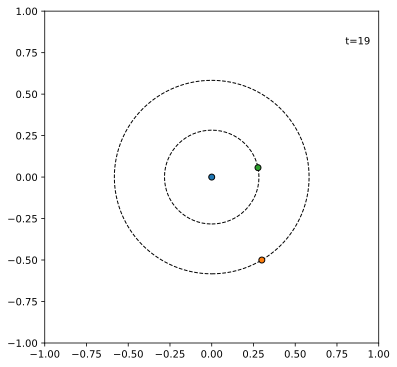

In [55]:
particles = [
    Particle( 0.0,  0.0, +1.0),
    Particle( 0.3, -0.5,  0.0),
    Particle(+0.2, +0.2, +0.3)
]

simulator = ParticleSimulator(particles)
visualize_simulation(simulator, timesteps=20, fps=5, savename='particles-test.gif') # fps = no. time steps per second => 4 second GIF

```{figure} particles-test.gif
```

## Tests and benchmarks

Makes sure things still work when we optimize and refactor. 

**Unit tests:** Verify the intended logic of the program regardless of the implementation details, which may change during optimization.

benchmark fixture

In [8]:
from test.test_particles import test_evolve

test_evolve??

Signature: test_evolve()
Docstring: <no docstring>
Source:   
def test_evolve():
    particles = [
        Particle( 0.0,  0.0, +1),
        Particle( 0.0, -0.5,  0),
        Particle(+0.2, +0.2, +3)
    ]

    simulator = ParticleSimulator(particles)
    simulator.evolve(0.1)

    p0, p1, p2 = particles

    assert np.isclose(p0.x,  0.0)
    assert np.isclose(p0.y,  0.0)
    assert np.isclose(p1.x,  0.0)
    assert np.isclose(p1.y, -0.5)
    assert np.isclose(p2.x, (0.2 ** 2 + 0.2 ** 2) ** 0.5 * math.cos(math.pi / 4 + 0.3))
    assert np.isclose(p2.y, (0.2 ** 2 + 0.2 ** 2) ** 0.5 * math.sin(math.pi / 4 + 0.3))
File:      ~/code/fitter-happier-models/docs/notebooks/hp/test/test_particles.py
Type:      function


In [9]:
!pytest test -v -s

============================= test session starts ==============================
platform darwin -- Python 3.9.15, pytest-7.2.0, pluggy-1.0.0 -- /Users/particle1331/opt/miniconda3/envs/ai/bin/python3.9
cachedir: .pytest_cache
benchmark: 4.0.0 (defaults: timer=time.perf_counter disable_gc=False min_rounds=5 min_time=0.000005 max_time=1.0 calibration_precision=10 warmup=False warmup_iterations=100000)
rootdir: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp
plugins: anyio-3.6.2, benchmark-4.0.0
collected 1 item                                                               

test/test_particles.py::test_evolve PASSED

============================== 1 passed in 0.40s ===============================


setup -> benchmark fixture to determine exact function to benchmark

Tests ensure the correctness of our functionality but gives little information about its
running time. A **benchmark** is a simple and representative use case that can be run to
assess the running time of an application. Benchmarks are very useful to keep score of
how fast our program is with each new version that we implement. For an accurate measurement, the benchmark should be designed to have a long
enough execution time (in the order of seconds) so that the setup and teardown of the
process are small compared to the execution time of the application. 

## Line profiling

Profiling functions line-by-line can be useful after determining bottlenecks in the execution. Note that this is only useful if the flow of execution is clear from the code. Thus, in addition to writing code such that it is easily testable, we should also try to write code that can be easily time and memory profiled. Fortunately, this generally already follows after following clean code practices. 

In [10]:
from src.particles import benchmark, random_particles

random_particles??

Signature: random_particles(n: int) -> list[src.particles.Particle]
Docstring: <no docstring>
Source:   
def random_particles(n: int) -> list[Particle]:
    particles = []
    for _ in range(n):
        x, y, ω = np.random.random(3)
        particles.append(Particle(x, y, ω))
    return particles
File:      ~/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Type:      function


In [11]:
benchmark??

Signature: benchmark()
Docstring: <no docstring>
Source:   
def benchmark():
    particles = random_particles(100)
    simulator = ParticleSimulator(particles)
    simulator.evolve(0.5)
File:      ~/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Type:      function


In [12]:
%load_ext line_profiler

In [13]:
%lprun -f random_particles random_particles(100)

Timer unit: 1e-06 s

Total time: 0.001285 s
File: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Function: random_particles at line 98

Line #      Hits         Time  Per Hit   % Time  Line Contents
    98                                           def random_particles(n: int) -> list[Particle]:
    99         1          1.0      1.0      0.1      particles = []
   100       101         43.0      0.4      3.3      for _ in range(n):
   101       100       1017.0     10.2     79.1          x, y, ω = np.random.random(3)
   102       100        224.0      2.2     17.4          particles.append(Particle(x, y, ω))
   103         1          0.0      0.0      0.0      return particles

In [14]:
%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 0.619326 s
File: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Function: benchmark at line 105

Line #      Hits         Time  Per Hit   % Time  Line Contents
   105                                           def benchmark():
   106         1        269.0    269.0      0.0      particles = random_particles(100)
   107         1         82.0     82.0      0.0      simulator = ParticleSimulator(particles)
   108         1     618975.0 618975.0     99.9      simulator.evolve(0.5)

## Optimizing our code

Now that we know where the bottleneck to our code is, we can start optimizing this part of the code. To make our code faster, we use vectorization with `numpy`:

```python
# src/particles.py

class ParticleSimulator:
    def __init__(self, particles: list[Particle], h=1e-5):
        self.h = h  # Euler-method increment 
        self.particles = particles
        self.data = np.array([[p.x, p.y, p.ω] for p in particles], dtype=np.float32)

    def evolve(self, t: float):
        """Evolve system from t=0 to t=t."""
        
        n_steps = int(t / self.h)
        for _ in range(n_steps):
            self.update_data()

        for i, p in enumerate(particles):
            p.x, p.y = self.data[i, [0, 1]]

    def update_data(self):
        """Evolve particle with Δt = h."""
        x = self.data[:, [0]]
        y = self.data[:, [1]]
        ω = self.data[:, [2]]
        vx = -y * ω
        vy =  x * ω
        dx = vx * self.h
        dy = vy * self.h
        self.data[:, [0]] += dx
        self.data[:, [1]] += dy
```

Running with updated (auto reload)

In [15]:
from src.particles import ParticleSimulator
%lprun -f benchmark benchmark()

Timer unit: 1e-06 s

Total time: 0.619902 s
File: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py
Function: benchmark at line 105

Line #      Hits         Time  Per Hit   % Time  Line Contents
   105                                           def benchmark():
   106         1        278.0    278.0      0.0      particles = random_particles(100)
   107         1         64.0     64.0      0.0      simulator = ParticleSimulator(particles)
   108         1     619560.0 619560.0     99.9      simulator.evolve(0.5)

Note that the execution time has been reduced by one order of magnitude.

## Memory profiling

In [49]:
from src.particles import benchmark_memory

In [50]:
%load_ext memory_profiler
%mprun -f benchmark_memory benchmark_memory()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler



Filename: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   120     54.3 MiB     54.3 MiB           1   def benchmark_memory():
   121    117.2 MiB     62.9 MiB           1       particles = random_particles(100000)
   122    120.4 MiB      3.2 MiB           1       simulator = ParticleSimulator(particles)
   123    126.1 MiB      5.7 MiB           1       simulator.evolve(0.001)

From the Increment column, we can see that 100,000 Particle objects take 23.7
MiB of memory.
1 mebibyte (MiB) is equivalent to 1,048,576 bytes. It is different from 1 megabyte (MB),
which is equivalent to 1,000,000 bytes.
We can use __slots__ on the Particle class to reduce its memory footprint. This
feature saves some memory by avoiding storing the variables of the instance in an internal
dictionary. This strategy, however, has a small limitation—it prevents the addition of
attributes other than the ones specified in __slots__. You can see this feature in use
in the following code snippet: 

In [52]:
from src.particles import Particle, ParticleSimulator
%reload_ext memory_profiler 
%mprun -f benchmark_memory benchmark_memory()

Filename: /Users/particle1331/code/fitter-happier-models/docs/notebooks/hp/src/particles.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   120     57.5 MiB     57.5 MiB           1   def benchmark_memory():
   121    110.3 MiB     52.8 MiB           1       particles = random_particles(100000)
   122    113.5 MiB      3.2 MiB           1       simulator = ParticleSimulator(particles)
   123    119.9 MiB      6.4 MiB           1       simulator.evolve(0.001)

Using slots resulted in 62.9 MiB to 52.8 MiB. Note that memory_profiling has issues with garbage collection. 

Here the Increment column shows how much each row affects the total memory consumption while Mem usage is the cumulative memory use.